<a href="https://colab.research.google.com/github/Poirazi-Lab/dendrify/blob/main/paper_figures/Fig3_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
> *In this interactive Python notebook, we present and briefly discuss the code needed to replicate the model and the results shown in Figure 3 of the manuscript. In this example our goal is to illustrate:*
>
> - *More Dendrify features that allow modelling dendritic voltage-gated ion channels (VGICs) phenomenologically without using the Hodgkin-Huxley equations.*
>
> - *That with Dendrify it is possible to create simplified compartmental integrate and fire (I&F) models reproducing numerous biological dendritic functions.*
>
>
> <hr>
>
> *__Note__: In case you are unfamiliar with how Python notebooks work and you would like to run or rerun the entire code, simply select one of the options bellow:*
>
> - **Runtime ➝ Run all**
> - **Runtime ➝ Restart and run all**
>
> *located on the top menu and wait a few seconds until all cells finish running.*
> <hr>
>
> *All source code of the current Dendrify version is available on* [GitHub](https://github.com/Poirazi-Lab/dendrify)

## Setup

In [1]:
#@title Install dependencies (might take a few seconds)
!pip install brian2 --quiet
!pip install dendrify --quiet

In [2]:
#@title Imports and settings
import brian2 as b
from brian2.units import (ms, um, pA, nS, uS, ohm, cm, mV, uF, mvolt) # Generally a better practise than * imports
from dendrify import Soma, Dendrite, NeuronModel

b.prefs.codegen.target = 'numpy' # Improves performance significantly here
b.start_scope()    # allows running separate simulations in the same notebook

# @title Figure settings
blue = '#005c94ff'
green = '#338000ff'
orange = '#ff6600ff'
notred = '#aa0044ff'
params = {
          "legend.fontsize": 10,
          "legend.handlelength": 1.5,
          "legend.edgecolor": 'inherit',
          "legend.columnspacing": 0.8,
          "legend.handletextpad": 0.5,
          "axes.labelsize": 10,
          "axes.titlesize": 11, 
          "axes.spines.right": False,
          "axes.spines.top": False,
          "xtick.labelsize": 10,
          "ytick.labelsize": 10,
          'mathtext.default': 'regular',
          'lines.markersize': 3,
          'lines.linewidth': 1.25,
          'grid.color': "#d3d3d3",
          'text.antialiased': True,
          'lines.antialiased': True,
          'figure.dpi': 150,
          'axes.prop_cycle': b.cycler(color=[blue, green, orange, notred])
          }

b.rcParams.update(params)

## Build model
> *Let's first creat a 4-compartment toy model with active dendritic mechanism:*

In [3]:
# create soma
soma = Soma('soma', model='leakyIF', length=25*um, diameter=25*um )

# create trunk
trunk = Dendrite('trunk', length=100*um, diameter=2.5*um)
trunk.dspikes('Na', threshold=-35*mV, g_rise=34*nS, g_fall=27.2*nS)

# create proximal dendrite
prox = Dendrite('prox', length=100*um, diameter=1*um)
prox.synapse('AMPA', pre='pathY', g=0.8*nS,  t_decay=2*ms)
prox.synapse('NMDA', pre='pathY', g=0.8*nS,  t_decay=60*ms)
prox.dspikes('Na', threshold=-35*mV, g_rise=15.3*nS, g_fall=12.24*nS)

# create distal dendrite
dist = Dendrite('dist', length=100*um, diameter=0.5*um)
dist.synapse('AMPA', pre='pathX', g=0.8*nS,  t_decay=2*ms)
dist.synapse('NMDA', pre='pathX', g=0.8*nS,  t_decay=60*ms)
dist.dspikes('Na', threshold=-35*mV, g_rise=7*nS, g_fall=5.6*nS)

# merge compartments into a  neuron model and set its basic properties
edges = [(soma, trunk, 15*nS), (trunk, prox, 10*nS), (prox, dist, 4*nS)]
pyr_model = NeuronModel(edges, cm=1*uF/(cm**2), gl=40*uS/(cm**2),
                        v_rest=-70*mV, r_axial=150*ohm*cm,
                        scale_factor=2.8, spine_factor=1.5)

# set Na spikes properties
pyr_model.dspike_properties('Na', tau_rise=0.6*ms, tau_fall=1.2*ms,
                            refractory=5*ms, offset_fall=0.2*ms)

# create a Brian NeuronGroup and link it to the neuron model
pyr_group = b.NeuronGroup(3, model=pyr_model.equations, method='euler',
                          threshold='V_soma > -40*mV', reset='V_soma = 40*mV',
                          refractory=4*ms, events=pyr_model.events,
                          namespace=pyr_model.parameters)
pyr_model.link(pyr_group)

#-------------------------dendrify workflow ends here--------------------------#

In [4]:
# a little trick for having somatic spikes with more realistic shape which also
# allows the generation of backpropagating dendritic spikes
second_reset = b.Synapses(pyr_group, pyr_group, on_pre='V_soma=-55*mV', delay=0.5*ms)
second_reset.connect(j='i')

> *We can inspect what Dendrify did for us by simply printing the NeuronModel object we created. As we see, compared to the model shown in Fig. 2, this model is significantly more complex.*

In [5]:
print(pyr_model)

OBJECT TYPE:

  <class 'dendrify.neuronmodel.NeuronModel'>

---------------------------------------------

PROPERTIES (type): 

→ equations (str):
    dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma) / C_soma  :volt
    I_soma = I_ext_soma + I_trunk_soma   :amp
    I_ext_soma  :amp
    I_trunk_soma = (V_trunk-V_soma) * g_trunk_soma  :amp
    
    dV_trunk/dt = (gL_trunk * (EL_trunk-V_trunk) + I_trunk) / C_trunk  :volt
    I_trunk = I_ext_trunk + I_prox_trunk  + I_soma_trunk  + I_Na_trunk + I_Kn_trunk  :amp
    I_ext_trunk  :amp
    I_Na_trunk = g_Na_trunk * (E_Na-V_trunk)  :amp
    I_Kn_trunk = g_Kn_trunk * (E_K-V_trunk)  :amp
    dg_Na_trunk/dt = -g_Na_trunk/tau_Na  :siemens
    dg_Kn_trunk/dt = -g_Kn_trunk/tau_Kn  :siemens
    allow_I_Na_trunk  :boolean
    allow_I_Kn_trunk  :boolean
    timer_Na_trunk  :second
    I_soma_trunk = (V_soma-V_trunk) * g_soma_trunk  :amp
    I_prox_trunk = (V_prox-V_trunk) * g_prox_trunk  :amp
    
    dV_prox/dt = (gL_prox * (EL_prox-V_prox) + I_prox)

> *Our model now looks somewhat like this:*
>
><p align="center">
    <img src="https://github.com/Poirazi-Lab/dendrify/blob/main/paper_figures/graphics/2.png?raw=true" alt="model" width="25%">
></p>
>
> *Let's use it to replicate the experiments shown in Figure 4.*

## Panels b-e | dSpike initiation and propagation
> *To test the impact of locally generated Na+ spikes on dendritic and somatic responses we simulated the application of short current injections (5 ms long pulses of rheobase intensity) to each dendritic segment and recorded the voltage responses of all compartments.*

In [6]:
# set monitors to record membrane voltages
vars = ["V_soma", "V_trunk", "V_prox", "V_dist"]
M = b.StateMonitor(pyr_group, vars, record=True)

# first 5 ms -> no input
b.run(5*ms)

# next 5 ms -> square pulse for crossing dSpike threshold
pyr_group.I_ext_dist[0] = 123 * pA
pyr_group.I_ext_prox[1] = 309 * pA
pyr_group.I_ext_trunk[2] = 560 * pA
b.run(5*ms)

# next 40 ms -> no input to let membranes return closer to Vrest
pyr_group.I_ext_dist[0] = 0 * pA
pyr_group.I_ext_prox[1] = 0 * pA
pyr_group.I_ext_trunk[2] = 0 * pA
b.run(40*ms)

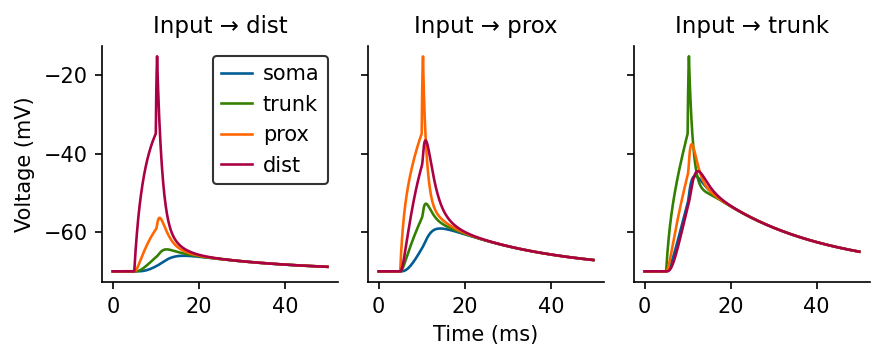

In [7]:
#@title Plot voltage traces
time = M.t/ms
vs = M.V_soma/mV
vt = M.V_trunk/mV
vp = M.V_prox/mV
vd = M.V_dist/mV

fig, axes = b.subplots(1, 3, figsize=[6,2.5], sharex=True, sharey=True)
ax0, ax1, ax2 = axes

for id, ax in enumerate(axes):
    for v, l in zip([vs, vt, vp, vd], ['soma', 'trunk', 'prox', 'dist']):
        ax.plot(time, v[id], label=l)

ax0.legend()
ax0.set_title('Input \u2192 dist')
ax0.set_ylabel('Voltage (mV)')
ax1.set_xlabel('Time (ms)')
ax1.set_title('Input \u2192 prox')
ax2.set_title('Input \u2192 trunk')
fig.tight_layout()

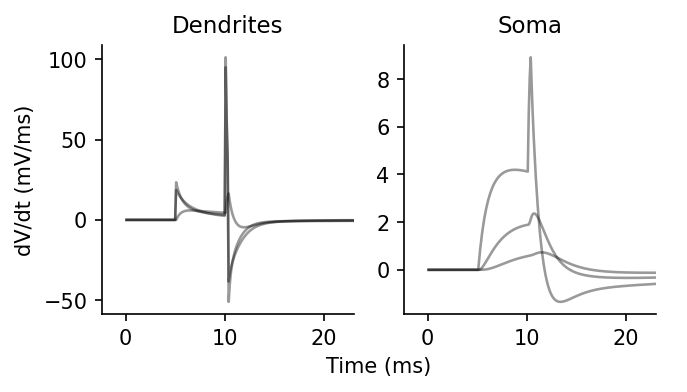

In [8]:
#@title Plot first temporal derivatives of Voltage
fig, axes = b.subplots(1, 2, figsize=[5, 3], sharex=True)
ax0, ax1 = axes
secret_ax = fig.add_subplot(111, frameon=False)
secret_ax.tick_params(labelcolor='none', which='both', bottom=False, left=False)


steps = b.arange(0.1, 50, 0.1)
dvdt_dist =  b.diff(vd[0]) / (0.1)
dvdt_prox =  b.diff(vp[1]) / (0.1)
dvdt_trunk =  b.diff(vp[2]) / (0.1)
dvdt_som0 =  b.diff(vs[0]) / (0.1)
dvdt_som1 =  b.diff(vs[1]) / (0.1)
dvdt_som2 =  b.diff(vs[2]) / (0.1)

for dend, som in zip([dvdt_dist, dvdt_prox, dvdt_trunk],
                     [dvdt_som0, dvdt_som1, dvdt_som2]):
    ax0.plot(steps, dend, alpha=0.4, c='black')
    ax1.plot(steps, som, alpha=0.4, c='black')

ax0.set_xlim(right=23)
ax0.set_ylabel('dV/dt (mV/ms)')
ax0.set_title('Dendrites')
ax1.set_title('Soma')
secret_ax.set_xlabel('Time (ms)')
fig.tight_layout()

> *Although model parameters were adjusted to elicit nearly identical dSpikes in all dendrites, somatic responses varied significantly, depending on the dSpike initiation site. As in real neurons, distal dSpikes became much weaker and broader as they travel towards the soma due to the dendritic filtering effect.*

## Panel f | Input-output curves
> *To examine how dendritic spiking combined with local branch properties affect synaptic integration, we will activate quasi-simultaneously (train of spikes with ISI 0.1 ms) an increasing number of synapses placed on the distal and the proximal segments. We will then compared the peak amplitude of the dendritic voltage responses (Actual) to what would be obtained by a linear arithmetic sum of unitary responses (Expected).*
>
> *ISI = inter-spike interval

> *Apply the stimulation protocol first on the distal dendrite*

In [9]:
# create a new Brian NeuronGroup and link it to the existing NeuronModel
b.start_scope()    # allows running separate simulations in the same notebook
b.defaultclock.dt = 0.05*ms    # increases simulation accuracy (default: 0.1 ms)
Nsyn_d = 15    # 15 synapses are enough since distal dendrites are very excitable

# create a Brian NeuronGroup and link it to the neuron model
pyr_group2 = b.NeuronGroup(Nsyn_d, model=pyr_model.equations, method='euler',
                          refractory=4*ms, events=pyr_model.events,
                          namespace=pyr_model.parameters)
pyr_model.link(pyr_group2)

# synaptic protocol: Nsyn_d presynaptic spikes with isi of 0.1 ms commonly used
# by experimental labs
start = 20*ms
isi = 0.1*ms
spiketimes = [(start + (i*isi)) for i in range(Nsyn_d)]
I = b.SpikeGeneratorGroup(Nsyn_d, range(Nsyn_d), spiketimes)

synaptic_effect = "s_AMPA_pathX_dist += 1.0; s_NMDA_pathX_dist += 1.0"
S = b.Synapses(I, pyr_group2, on_pre=synaptic_effect)
S.connect('j >= i')

In [10]:
spiketimes

[20. * msecond,
 20.1 * msecond,
 20.2 * msecond,
 20.3 * msecond,
 20.4 * msecond,
 20.5 * msecond,
 20.6 * msecond,
 20.7 * msecond,
 20.8 * msecond,
 20.9 * msecond,
 21. * msecond,
 21.1 * msecond,
 21.2 * msecond,
 21.3 * msecond,
 21.4 * msecond]

In [11]:
# set monitors to record membrane voltages and run simulation
M = b.StateMonitor(pyr_group2, ["V_dist"], record=True)
b.run(200 *ms)
vd = M.V_dist/mV

In [12]:
# create a new Brian NeuronGroup and link it to the existing NeuronModel
b.start_scope()    # allows running separate simulations in the same notebook
b.defaultclock.dt = 0.05*ms    # increase the simulation accuracy  

# create a Brian NeuronGroup and link it to the neuron model
pyr_group3 = b.NeuronGroup(Nsyn_d, model=pyr_model.equations, method='euler',
                          refractory=4*ms, events=pyr_model.events,
                          namespace=pyr_model.parameters)
pyr_model.link(pyr_group3, automate='v_rest')

# synaptic protocol
I = b.SpikeGeneratorGroup(Nsyn_d, range(Nsyn_d), spiketimes)

synaptic_effect = "s_AMPA_pathX_dist += 1.0; s_NMDA_pathX_dist += 1.0"
S = b.Synapses(I, pyr_group3, on_pre=synaptic_effect)
S.connect('j >= i')

# set monitors to record membrane voltages and run simulation
M = b.StateMonitor(pyr_group3, ["V_dist"], record=True)
b.run(200 *ms)
vd_ttx = M.V_dist/mV

> *Note: We are exploring ways on making Dendrify more flexible when it comes to performing multiple simulations with different parameters or mechanisms. Some of them include:*
- *Being able to alter/remove NeuronModel mechanisms more easily.*
- *Being able to use the same NeuronModel with multiple NeuronGroups in the same simulation (might work now but it's  not thoroughly tested).*
>
> *Since Dendrify is a project in active development many improvements & features will be included in future versions.*

In [13]:
#@title Repeat process fot the proximal dendrite
# create a new Brian NeuronGroup and link it to the existing NeuronModel
b.start_scope()    # allows running separate simulations in the same notebook
b.defaultclock.dt = 0.05*ms    # increases simulation accuracy (default: 0.1 ms)
Nsyn_p = 30    # more synapses than before since prox is less excitable

# create a Brian NeuronGroup and link it to the neuron model
pyr_group4 = b.NeuronGroup(Nsyn_p, model=pyr_model.equations, method='euler',
                          refractory=4*ms, events=pyr_model.events,
                          namespace=pyr_model.parameters)
pyr_model.link(pyr_group4)

# synaptic protocol
spiketimes = [(start + (i*isi)) for i in range(Nsyn_p)]
I = b.SpikeGeneratorGroup(Nsyn_p, range(Nsyn_p), spiketimes)

synaptic_effect = "s_AMPA_pathY_prox += 1.0; s_NMDA_pathY_prox += 1.0"
S = b.Synapses(I, pyr_group4, on_pre=synaptic_effect)
S.connect('j >= i')

# Set monitors to record membrane voltages and run simulation
M = b.StateMonitor(pyr_group4, ["V_prox"], record=True)
b.run(200 *ms)
vp = M.V_prox/mV

################################################################################

# create a new Brian NeuronGroup and link it to the existing NeuronModel
b.start_scope()    # allows running separate simulations in the same notebook
b.defaultclock.dt = 0.05*ms    # increases simulation accuracy (default: 0.1 ms)

# create a Brian NeuronGroup and link it to the neuron model
pyr_group5 = b.NeuronGroup(Nsyn_p, model=pyr_model.equations, method='euler',
                          refractory=4*ms, events=pyr_model.events,
                          namespace=pyr_model.parameters)
pyr_model.link(pyr_group5, automate='v_rest')

# synaptic protocol
I = b.SpikeGeneratorGroup(Nsyn_p, range(Nsyn_p), spiketimes)

synaptic_effect = "s_AMPA_pathY_prox += 1.0; s_NMDA_pathY_prox += 1.0"
S = b.Synapses(I, pyr_group5, on_pre=synaptic_effect)
S.connect('j >= i')

# Set monitors to record membrane voltages and run simulation
M = b.StateMonitor(pyr_group5, ["V_prox"], record=True)
b.run(200 *ms)
vp_ttx = M.V_prox/mV

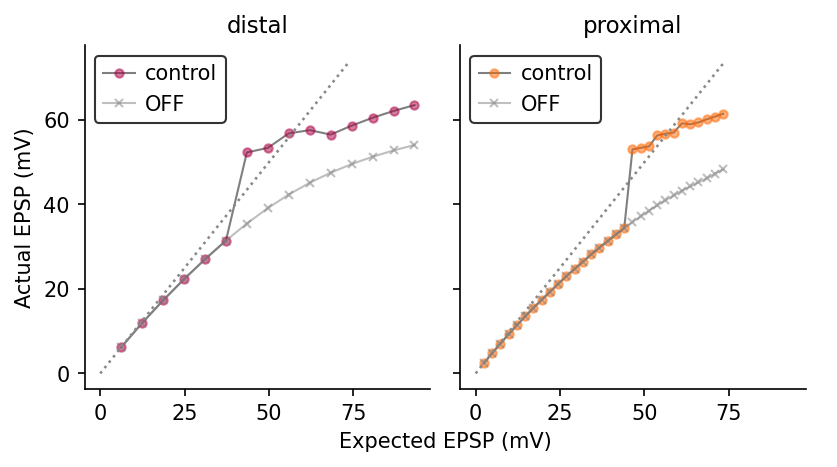

In [14]:
# @title Plot expected vs actual
time = M.t/ms

peaks_d = [max(v)+70 for v in vd]
unitary_d = peaks_d[0]
expected_d = b.linspace(1, Nsyn_d, Nsyn_d) * unitary_d

peaks_d_ttx = [max(v)+70 for v in vd_ttx]
unitary_d_ttx = peaks_d_ttx[0]
expected_d_ttx = b.linspace(1, Nsyn_d, Nsyn_d) * unitary_d_ttx

peaks_p = [max(v)+70 for v in vp]
unitary_p = peaks_p[0]
expected_p = b.linspace(1, Nsyn_p, Nsyn_p) * unitary_p

peaks_p_ttx = [max(v)+70 for v in vp_ttx]
unitary_p_ttx = peaks_p_ttx[0]
expected_p_ttx = b.linspace(1, Nsyn_p, Nsyn_p) * unitary_p_ttx

fig, axes = b.subplots(1, 2, sharex=True, sharey=True, figsize=[6,3.5])
ax0, ax1 = axes

ax0.plot(expected_d, peaks_d, "o-", ms=4, c='black', lw=1, mfc='#aa0044ff',
          mec='#aa0044ff', alpha=0.5, label='control')
ax0.plot(expected_d_ttx, peaks_d_ttx, "x-", ms=4, c='gray', lw=1, alpha=0.5, label='OFF')
ax0.plot(range(75), range(75), c='#888a85ff', ls=':' )
ax0.set_ylabel('Actual EPSP (mV)')
ax0.set_title('distal')
ax0.legend()

ax1.plot(expected_p, peaks_p, "o-", ms=4, c='black', lw=1, mfc='#ff6600ff',
          mec='#ff6600ff', alpha=0.5, label='control')
ax1.plot(expected_p_ttx, peaks_p_ttx, "x-", ms=4, c='gray', lw=1, alpha=0.5, label='OFF')
ax1.plot(range(75), range(75), c='#888a85ff', ls=':' )
ax1.set_title('proximal')
ax1.legend()

secret_ax = fig.add_subplot(111, frameon=False)
secret_ax.tick_params(labelcolor='none', which='both', bottom=False, left=False)
secret_ax.set_xlabel('Expected EPSP (mV)')

fig.tight_layout()

> *Although the two segments appear to have similar input-output curves, dendritic nonlinearities emerge with less synapses in the distal compartment. This is because of its higher input resistance (Rinput), requiring less excitation to cross the dSpike threshold.*

## Panel g | Backpropagating action potentials

> *An import property of many biological neurons is the ability of spikes initiated in the perisomatic area to invade adjacent dendrites and propagate "backward", towards the dendritic tips. To test if our model can reproduce this phenomenon, we will inject a depolarizing step current at the soma (125 pA for 300 ms), capable of eliciting a small number of somatic APs, and record the dendritic voltage responses*

In [15]:
# create a Brian NeuronGroup and link it to the neuron model
b.start_scope()    # allows running separate simulations in the same notebook
b.defaultclock.dt = 0.1*ms    # set it back to normal
pyr_group = b.NeuronGroup(1, model=pyr_model.equations, method='euler',
                          threshold='V_soma > -40*mV', reset='V_soma = 40*mV',
                          refractory=4*ms, events=pyr_model.events,
                          namespace=pyr_model.parameters)
pyr_model.link(pyr_group)

# trick for having more realistic somatic spike
second_reset = b.Synapses(pyr_group, pyr_group, on_pre='V_soma=-55*mV', delay=0.5*ms)
second_reset.connect(j='i')

# set monitors to record membrane voltages
vars = ["V_soma", "V_trunk", "V_prox", "V_dist",
        'I_Na_dist', 'I_Kn_dist', 'I_Na_prox', 'I_Kn_prox', 
        'I_Na_trunk', 'I_Kn_trunk']
M = b.StateMonitor(pyr_group, vars, record=True)

# first 20 ms -> no input
b.run(20*ms)

# next 300 ms -> somatic current injection
pyr_group.I_ext_soma[0] = 125 *pA
b.run(300*ms)

# next 120 ms -> no current to let membranes return to Vrest
pyr_group.I_ext_soma[0] = 0 *pA
b.run(120*ms)

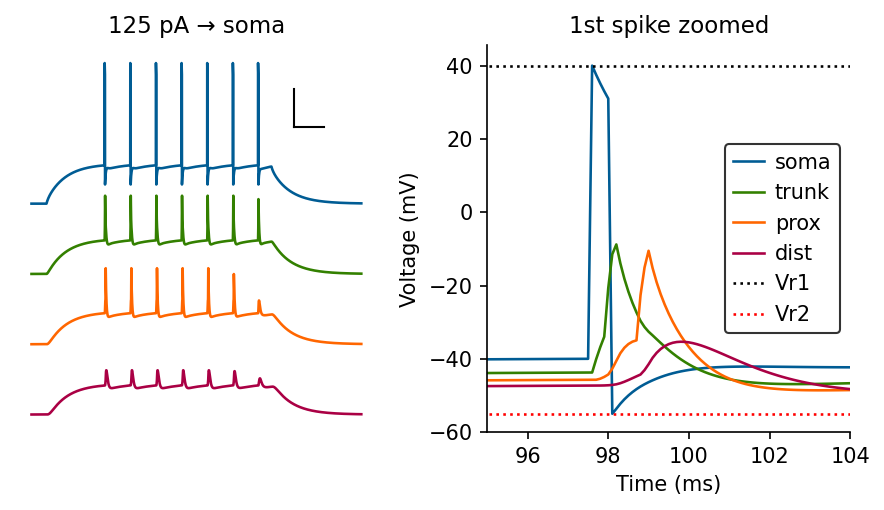

In [16]:
# @title Plot BPAPs
time = M.t/ms
vs = M.V_soma[0]/mV
vt = M.V_trunk[0]/mV
vp = M.V_prox[0]/mV
vd = M.V_dist[0]/mV

fig, axes = b.subplots(1,2, figsize=[6,3.5])
ax0, ax1 = axes

shift = 0
names = ['soma', 'trunk', 'prox', 'dist']
for v, name in zip([vs, vt, vp, vd], names):
    ax0.plot(time, v+shift)
    ax1.plot(time, v, label=name)
    shift -= 55

ax0.plot([350,390],[-10, -10], c='black', lw=1)
ax0.plot([350,350],[-10, 20], c='black', lw=1)
ax0.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
ax0.spines['bottom'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.set_title('125 pA \u2192 soma')

ax1.plot([0, 500], [40, 40], ls=':', c='black', label='Vr1')
ax1.plot([0, 500], [-55, -55], ls=':', c='red', label='Vr2')
ax1.set_xlim(left=95, right=104)
ax1.set_ylim(bottom=-60)
ax1.set_title('1st spike zoomed')
ax1.set_ylabel('Voltage (mV)')
ax1.set_xlabel('Time (ms)')
ax1.legend()

fig.tight_layout()

> *Backpropagating dSpikes are generated spontaneously in response to somatic current injections. The short-amplitude spikelets detected in the distal branch are subthreshold voltage responses for dSpike initiation. The doted lines indicate the double voltage reset mechanism we utilise to have somatic APs with more realistic shape (than ordinary I&F models). Scalebar: 40mV / 30ms.*

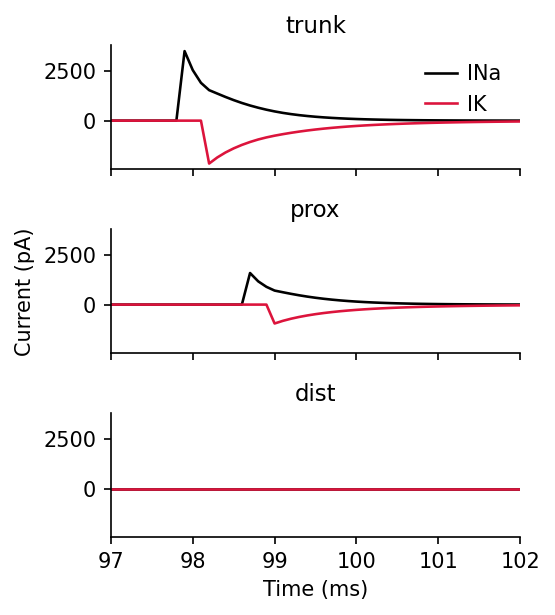

In [17]:
# @title Plot dendritic currents
ina_trunk = M.I_Na_trunk[0]/pA
ik_trunk = M.I_Kn_trunk[0]/pA
ina_prox = M.I_Na_prox[0]/pA
ik_prox = M.I_Kn_prox[0]/pA
ina_dist = M.I_Na_dist[0]/pA
ik_dist = M.I_Kn_dist[0]/pA

fig, axes = b.subplots(3, 1, figsize=[3.8,4.2], sharex=True, sharey=True)
ax0, ax1, ax2 = axes

ax0.plot(time, ina_trunk, c='black', label='INa')
ax0.plot(time, ik_trunk, c='crimson', label='IK')

ax1.plot(time, ina_prox, c='black')
ax1.plot(time, ik_prox, c='crimson')

ax2.plot(time, ina_dist, c='black')
ax2.plot(time, ik_dist, c='crimson')

ax0.set_xlim(left=97, right=102)
ax0.legend(loc=1, frameon=False)
ax0.set_title('trunk')
ax1.set_ylabel('Current (pA)')
ax1.set_title('prox')
ax2.set_xlabel('Time (ms)')
ax2.set_title('dist')

fig.tight_layout()

> *To increase simulation performance we introduce a new approach for modeling dSpikes, significantly more efficient and tractable than the Hodgkin-Huxley equations. See the equations bellow:*
>
>```
    I_Na_trunk = g_Na_trunk * (E_Na-V_trunk)  :amp
    I_Kn_trunk = g_Kn_trunk * (E_K-V_trunk)  :amp
    dg_Na_trunk/dt = -g_Na_trunk/tau_Na  :siemens
    dg_Kn_trunk/dt = -g_Kn_trunk/tau_Kn  :siemens
>```
> *Each current is simulated as an alpha function multiplied by the driving force of its ion. By using Brian's custom events we were able to describe the conditions that activate these currents. Dendrify takes care of the dSpike events in the background, without users having to worry about them.*


